<font size="4">  
    ML 5622 Final Project - Laptop Prices
</font> 
<font size="3">  
    <ul>
        <li>Dataset is taken from <a href="https://www.kaggle.com/datasets/owm4096/laptop-prices" target="_blank">Kaggle</a></li>  
    </ul>
</font> 
<font size="2"> 
    For complete analysis and write up please consult the <b>README</b>
</font>

In [383]:
# import libraries used from previous assignments
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# set color map to have light blue background
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm
%matplotlib inline

In [384]:
# connect to Kaggle dataset and display contents
df = pd.read_csv('laptop_prices.csv')
df.head()

,Company,Product,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,...,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
0,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,...,Yes,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640
1,Apple,Macbook Air,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,...,No,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000
2,HP,250 G6,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,...,No,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620
3,Apple,MacBook Pro,Ultrabook,15.4,16,macOS,1.83,2537.45,Standard,2880,...,Yes,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455
4,Apple,MacBook Pro,Ultrabook,13.3,8,macOS,1.37,1803.60,Standard,2560,...,Yes,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650


In [385]:
## Data Cleaning
# remove Apple products
i = df[(df.Company == 'Apple')].index
df = df.drop(i)
# remove unnecessary features / features I don't care about
df = df.drop(columns=['TypeName','Touchscreen','IPSpanel','RetinaDisplay'])
# rename price
df = df.rename(columns={'Price_euros': 'Price'})
# count how many rows actually have secondary storage
secondary_storage_value_counts = df['SecondaryStorage'].value_counts()
print('secondary_storage_value_counts: ', secondary_storage_value_counts)
# remove secondary storage - too few laptops actually have secondary storage
df = df.drop(columns=['SecondaryStorage','SecondaryStorageType'])
# inspect cleaned data for oddities
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #print(df)


secondary_storage_value_counts:  SecondaryStorage
0       1046
1024     187
2048      15
256        3
500        2
512        1
Name: count, dtype: int64


In [386]:
## EDA
# remove non numeric columns for heatmap
dfNumericFeatures = df[['Price', 'Inches', 'Ram', 'Weight', 'ScreenW', 'ScreenH', 'CPU_freq', 'PrimaryStorage']]
dfNumericFeatures.corr()

,Price,Inches,Ram,Weight,ScreenW,ScreenH,CPU_freq,PrimaryStorage
Price,1.000000,0.072659,0.740302,0.222636,0.546019,0.541465,0.433495,-0.125071
Inches,0.072659,1.000000,0.242094,0.822623,-0.061431,-0.079092,0.289342,0.262676
Ram,0.740302,0.242094,1.000000,0.394312,0.422181,0.415075,0.369484,0.015498
Weight,0.222636,0.822623,0.394312,1.000000,-0.018882,-0.033324,0.308523,0.171946
ScreenW,0.546019,-0.061431,0.422181,-0.018882,1.000000,0.995809,0.180323,-0.072722
ScreenH,0.541465,-0.079092,0.415075,-0.033324,0.995809,1.000000,0.170834,-0.078513
CPU_freq,0.433495,0.289342,0.369484,0.308523,0.180323,0.170834,1.000000,0.052322
PrimaryStorage,-0.125071,0.262676,0.015498,0.171946,-0.072722,-0.078513,0.052322,1.000000


<Axes: >

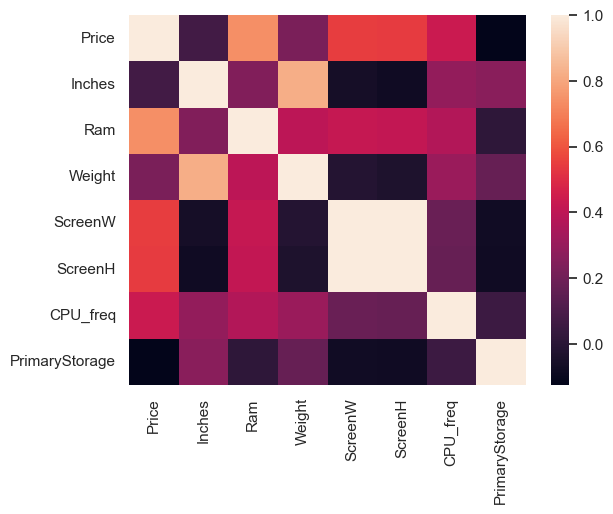

In [387]:
# visualizing coorelation matrix
sns.heatmap(dfNumericFeatures.corr())

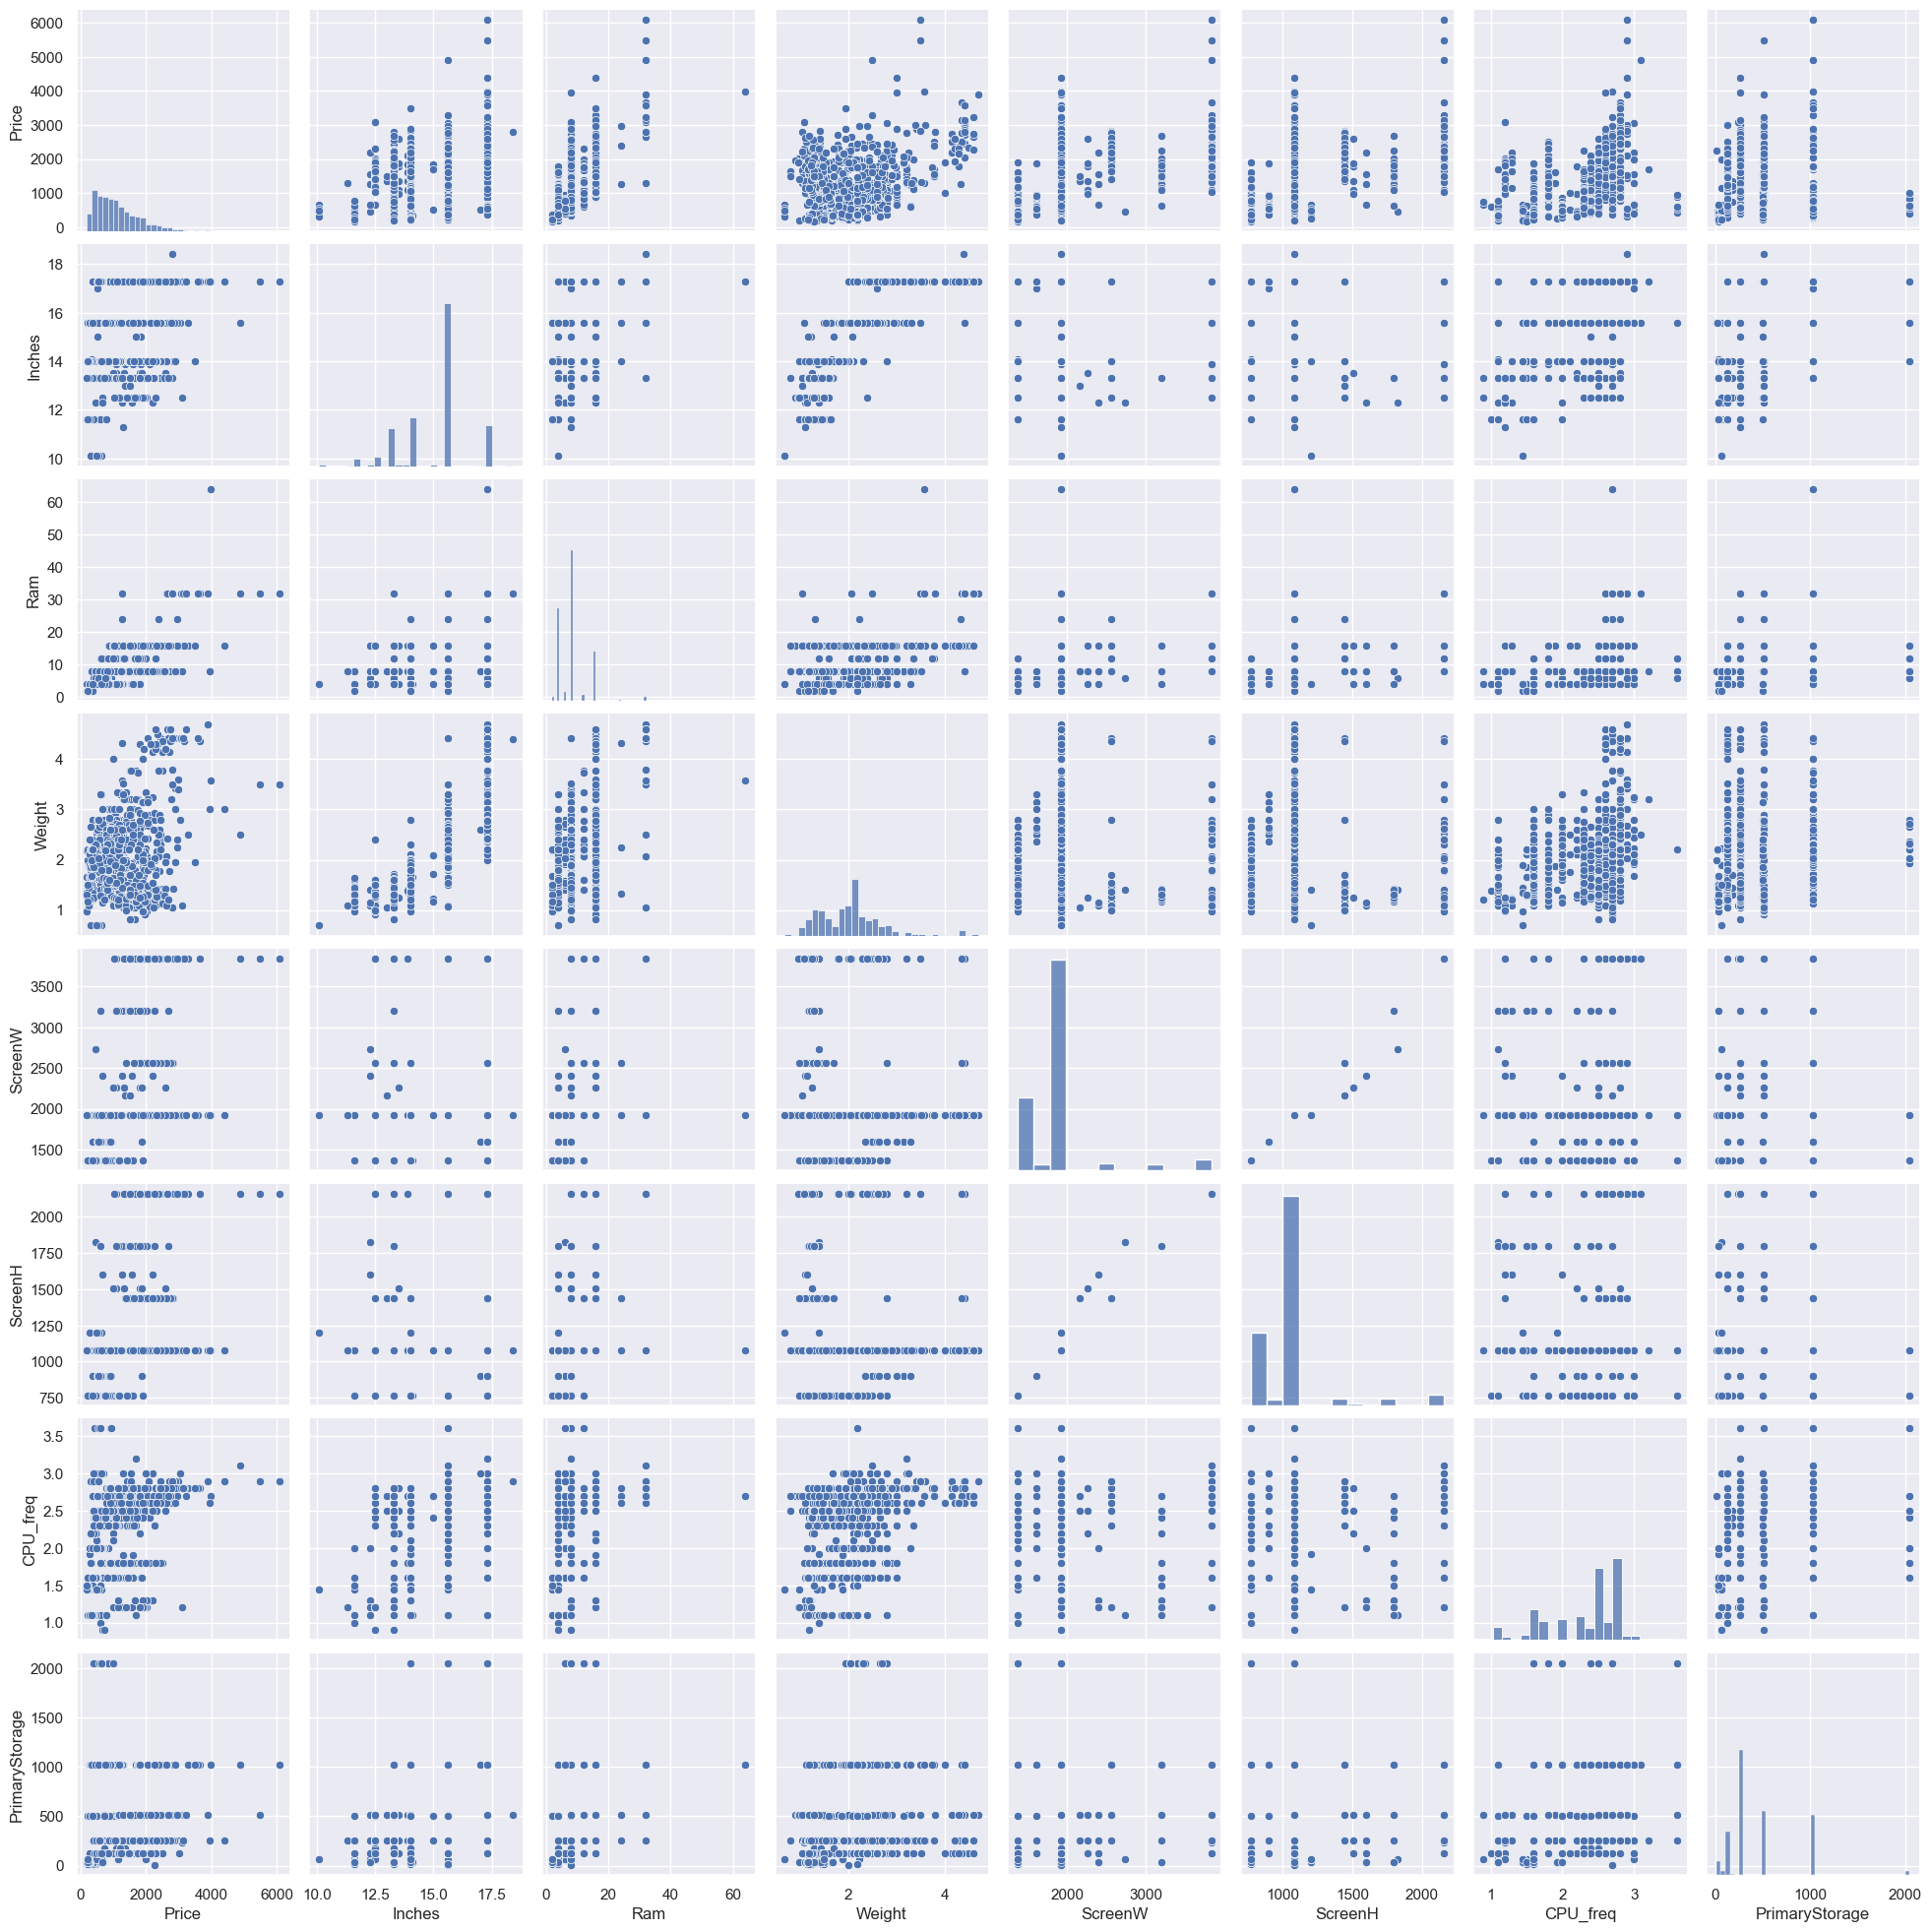

In [388]:
# inspecting relationships between features
dfNumericFeatures = dfNumericFeatures.apply(lambda x: pd.to_numeric(x, errors='coerce'))
sns.pairplot(dfNumericFeatures)
plt.show()

In [389]:
## Models
# starting with a simple linear regression model
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)
model_weight = smf.ols(formula='Price ~ Weight', data=df).fit()
print(model_weight.summary())
print('##############################################################################')
model_inches = smf.ols(formula='Price ~ Inches', data=df).fit()
print(model_inches.summary())
print('##############################################################################')
model_ram = smf.ols(formula='Price ~ Ram', data=df).fit()
print(model_ram.summary())
print('##############################################################################')
model_cpu_freq = smf.ols(formula='Price ~ CPU_freq', data=df).fit()
print(model_cpu_freq.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     65.29
Date:                Mon, 14 Oct 2024   Prob (F-statistic):           1.51e-15
Time:                        22:23:16   Log-Likelihood:                -9963.4
No. Observations:                1254   AIC:                         1.993e+04
Df Residuals:                    1252   BIC:                         1.994e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    647.5108     62.491     10.362      0.0

In [390]:
# multi-linear regression model
model_multi = smf.ols('Price ~ Ram + Weight + CPU_freq', data=df).fit() 
print(model_multi.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     599.2
Date:                Mon, 14 Oct 2024   Prob (F-statistic):          2.74e-241
Time:                        22:23:16   Log-Likelihood:                -9436.5
No. Observations:                1254   AIC:                         1.888e+04
Df Residuals:                    1250   BIC:                         1.890e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -105.0115     64.575     -1.626      0.1

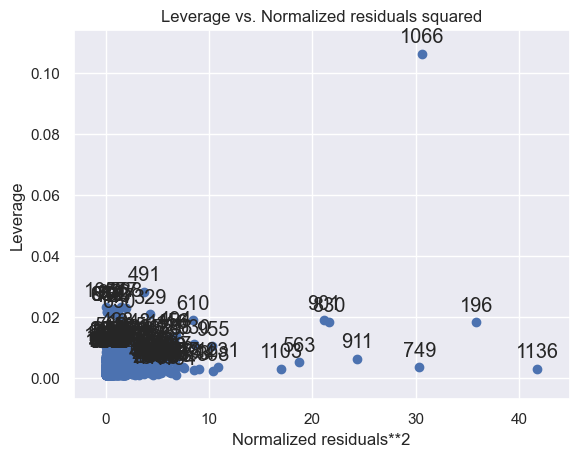

In [391]:
# plot the leverage vs. the square of the residual
sm.graphics.plot_leverage_resid2(model_multi)
plt.show()

In [392]:
# list of indices for high-leverage and/or high-residual points
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #print(df)

unusual = [1066,196,1136,749,911,563,901,1103,330,830,491,329,610,650,1086]
df = df.drop(unusual)[['Price', 'Ram', 'Weight', 'CPU_freq']]
formula = 'Price ~ Ram + Weight + CPU_freq'
model_final = smf.ols(formula, data=df).fit()
print(model_final.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     643.9
Date:                Mon, 14 Oct 2024   Prob (F-statistic):          6.46e-252
Time:                        22:23:16   Log-Likelihood:                -9184.9
No. Observations:                1239   AIC:                         1.838e+04
Df Residuals:                    1235   BIC:                         1.840e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -67.3810     58.149     -1.159      0.2

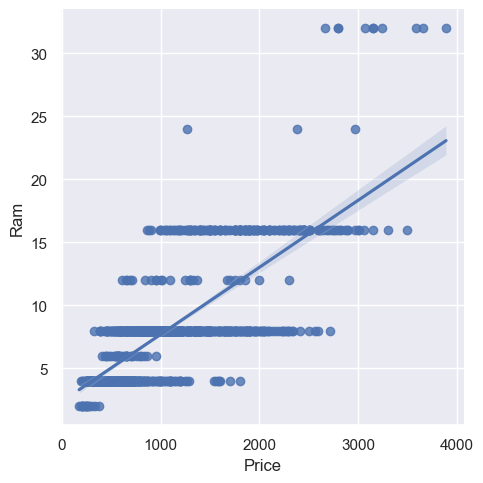

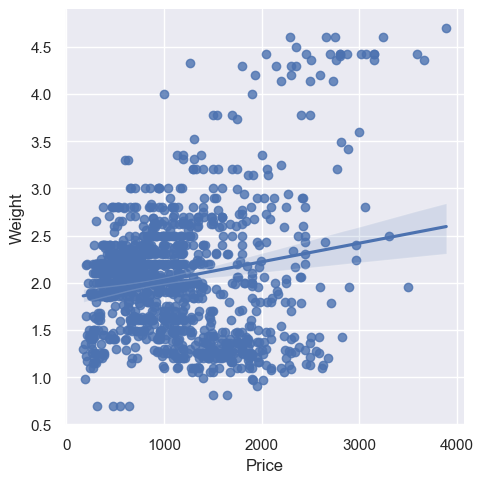

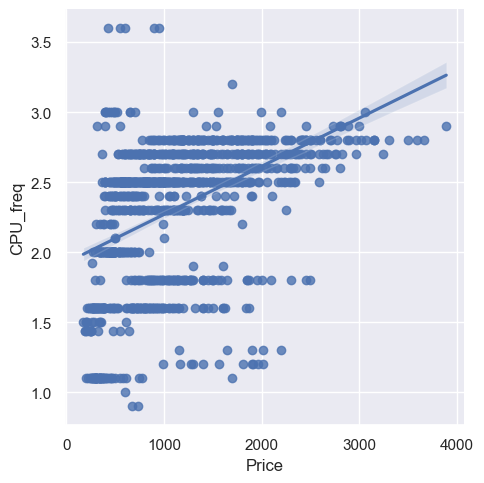

In [393]:
# plot regression model against features
sns.lmplot(x='Price',  y='Ram', data=df, fit_reg=True) 
plt.show()
sns.lmplot(x='Price',  y='Weight', data=df, fit_reg=True) 
plt.show()
sns.lmplot(x='Price',  y='CPU_freq', data=df, fit_reg=True) 
plt.show()

In [394]:
# cross validation using KFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
 
X = dfNumericFeatures.iloc[:,:-1]
y = dfNumericFeatures.iloc[:,-1]
kf = KFold(n_splits=5, random_state=None) # split data into 5 subsets
model = LogisticRegression(solver='liblinear') 
result = cross_val_score(model,X,y,cv=kf)
print("Avg accuracy: {}".format(result.mean()))

Avg accuracy: 0.4904892430278885


Visual Representation of K-Fold Cross Validation

![alt text](K-Fold.jpg)